# CQF Exam One

## January 2024 Cohort

Let us define the notation to be as follows:

$$R = \begin{pmatrix}
1 & 0.3 & 0.3 & 0.3 \\
0.3 & 1 & 0.6 & 0.6 \\
0.3 & 0.6 & 1 & 0.6 \\
0.3 & 0.6 & 0.6 & 1
\end{pmatrix}, \quad
\mathbb{1} = \begin{pmatrix}
1 \\
1 \\
1 \\
1
\end{pmatrix}, \quad
\mu = \begin{pmatrix}
0.02 \\
0.07 \\
0.15 \\
0.20
\end{pmatrix}, \quad
\sigma = \begin{pmatrix}
0.05 \\
0.12 \\
0.17 \\
0.25
\end{pmatrix}, \quad
S = \begin{pmatrix}
0.05 & 0 & 0 & 0 \\
0 & 0.12 & 0 & 0 \\
0 & 0 & 0.17 & 0 \\
0 & 0 & 0 & 0.25
\end{pmatrix}, \quad
w = \begin{pmatrix}
w_1 \\
w_2 \\
w_3 \\
w_4
\end{pmatrix}
$$

where $\sum_{i=1}^{n} w_i = 1$.

## Question 1.1
Consider the min-variance-portfolio with target return $m$.

**1.1.1**: The Langrangian for this problem is defined by
$$L(w, \lambda, \gamma) = \frac{1}{2}w^T \Sigma w + \lambda \left(m - w^T \mu\right) + \gamma\left(1-w^T\mathbb{1}\right)$$,
where $\Sigma = SRS$.
The partial derivatives are given by
$$\frac{\partial L}{\partial w}=\Sigma w -\lambda\mu - \gamma\mathbb{1}$$

$$\frac{\partial L}{\partial \lambda}=m - w^T \mu$$

$$\frac{\partial L}{\partial \gamma}=1 - w^T \mathbb{1}$$.

**1.1.2**:The optimal weight allocation vector $w^*$ (derived on sl. 66/142 ff. of the lecture notes "Fundamentals of Optimimization and Application to Portfolio Selection") is given by

$$w^*=\Sigma^{-1}\left(\lambda\mu+\gamma\mathbb{1}\right)$$,

where
$\lambda = \frac{Am-B}{AC-B^2}, \gamma = \frac{C-Bm}{AC-B^2}$
for the real numbers
$A=\mathbb{1}^T\Sigma^{-1}\mathbb{1}, B=\mu^T\Sigma^{-1}\mathbb{1}=\mathbb{1}^T\Sigma^{-1}\mu, C=\mu^T\Sigma^{-1}\mu$.

$w^*$ can then also be written as

$$w^*=\frac{1}{AC-B^2}\Sigma^{-1}\left[\left(A\mu-B\mathbb{1}\right)m+C\mathbb{1}-B\mu\right]$$.

**1.1.3**: Computing $w^*$ and $\sigma_\Pi=\sqrt{w^T\Sigma w}$ for $m=4.5\%$:

First, let us calculate $w^*$ using Python Numpy.

In [49]:
import numpy as np


np.set_printoptions(precision=3)  # round all printed results to precision decimals max. 3

mu = np.array([[0.08, 0.10, 0.10, 0.14]]).T
ones = np.ones((4, 1))
std_dev = np.array([0.12, 0.12, 0.15, 0.20]).T
R = np.array([[1, 0.3, 0.3, 0.3],
              [0.3, 1, 0.6, 0.6],
              [0.3, 0.6, 1, 0.6],
              [0.3, 0.6, 0.6, 1]])

def get_covariance_matrix(rho):
    return np.outer(std_dev, std_dev) * rho  # this is the same like std_dev * std_dev^T if std_dev is a column vector


def get_inverse_covariance_matrix(covariance):
    try:
        return np.linalg.inv(covariance)
    except np.linalg.LinAlgError as exc:
        print(f"Covariance matrix not invertible: {exc}")


def get_a_b_c(covariance_inv):  # slide 68
    a = np.linalg.multi_dot([ones.T, covariance_inv, ones])
    b = np.linalg.multi_dot([mu.T, covariance_inv, ones])
    c = np.linalg.multi_dot([mu.T, covariance_inv, mu])
    return a.item(), b.item(), c.item()  # item converts the np.array elements back into scalars


def get_optimized_weights(rho, target_return):  # sl. 69
    covariance = get_covariance_matrix(rho)
    covariance_inv = get_inverse_covariance_matrix(covariance)
    a, b, c = get_a_b_c(covariance_inv)
    optimized_weights = np.dot(covariance_inv, (a * mu - b * ones) * target_return + c * ones - b * mu)
    return optimized_weights / sum(optimized_weights)  # normalize weights so they sum up to 1


cov = get_covariance_matrix(R)
cov

array([[0.014, 0.004, 0.005, 0.007],
       [0.004, 0.014, 0.011, 0.014],
       [0.005, 0.011, 0.022, 0.018],
       [0.007, 0.014, 0.018, 0.04 ]])

In [50]:
cov_inv = get_inverse_covariance_matrix(cov)
cov_inv

array([[ 79.159, -10.794,  -8.636,  -6.477],
       [-10.794, 127.735, -36.701, -27.526],
       [ -8.636, -36.701,  81.75 , -22.021],
       [ -6.477, -27.526, -22.021,  45.984]])

In [51]:
weights = get_optimized_weights(R, 0.045)

In [52]:
print(f"The weight allocation vector is\n{weights}.")

The weight allocation vector is
[[ 0.975]
 [ 0.558]
 [ 0.355]
 [-0.888]].


For the portfolio risk  $\sigma_\Pi=\sqrt{w^T\Sigma w}$, we obtain:

In [53]:
sigma_pf = np.sqrt(np.linalg.multi_dot([np.transpose(weights), cov, weights]).item())
print(f"The portfolio risk equals {sigma_pf}.")

The portfolio risk equals 0.1648132614178332.


## Question 1.2
Calculate + plot portfolio risk and return for 700 random weight vectors.

In [54]:
import matplotlib.pyplot as plt


def generate_random_weights(number_of_assets, sample_size):
    # generate a matrix with random weights of dimensions (number_of_assets) x (sample_size)
    random_weights = np.random.rand(number_of_assets, sample_size)
    # ensure the weights (column vectors of the matrix) all sum up to one by normalizing the last row of the matrix
    random_weights[(number_of_assets-1), :] = 1 - random_weights[:(number_of_assets-1), :].sum(axis=0)
    return random_weights


def get_pf_risk_and_return(covariance_matrix, weights, mu):
    pf_risk = np.sqrt(np.linalg.multi_dot([weights.T, covariance_matrix, weights]).item())
    pf_return = np.dot(weights.T, mu)
    return pf_risk, pf_return


def calculate_efficient_frontier(rho, covariance_matrix, target_returns, mu):
    pf_risks_ef = []
    pf_returns_ef = []
    for target_return in target_returns:
        optimized_weight = get_optimized_weights(rho, target_return)
        pf_risk_ef, pf_return_ef = get_pf_risk_and_return(covariance_matrix, optimized_weight, mu)
        pf_risks_ef.append(pf_risk_ef)
        pf_returns_ef.append(pf_return_ef)
    return pf_risks_ef, pf_returns_ef

In [55]:
# sample size
N = 700
number_of_assets = 4

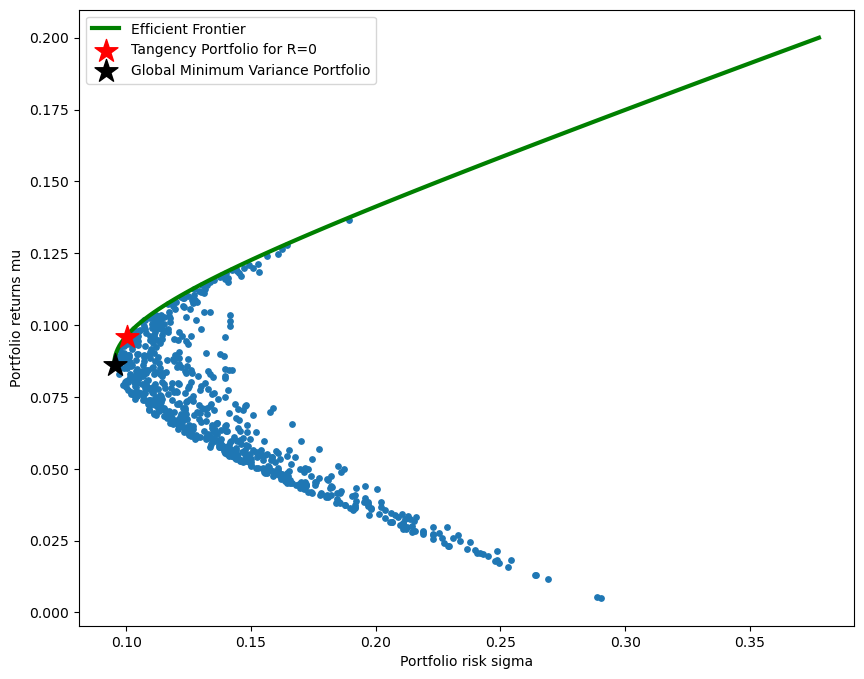

In [56]:
# calculate necessary plot arguments
random_weights = generate_random_weights(number_of_assets, N)
pf_risks = np.zeros(N)
pf_returns = np.zeros(N)
sharpe_ratio = 0.
k_tangency = -1
global_min_risk = 1000.
k_global_min_risk = -1

# calculate portfolio risk and returns, tangency pf + GMVP
for k in range(N):
    weights = random_weights[:, k]
    pf_risks[k], pf_returns[k] = get_pf_risk_and_return(cov, weights, mu)
    ratio = pf_returns[k] / pf_risks[k]
    if ratio > sharpe_ratio:
        sharpe_ratio = ratio
        k_tangency = k
    if pf_risks[k] < global_min_risk:
        global_min_risk = pf_risks[k]
        k_global_min_risk = k

# calculate the efficient frontier
ef_number_of_points = 100
target_returns = np.linspace(pf_returns[k_global_min_risk], 0.2, ef_number_of_points)
pf_risks_ef, pf_returns_ef = calculate_efficient_frontier(R, cov, target_returns, mu)


# plot
plt.figure(figsize=(10, 8))
plt.plot(np.reshape(pf_risks_ef, (ef_number_of_points, )), np.reshape(pf_returns_ef, (ef_number_of_points, )),
color="green", label="Efficient Frontier", linewidth=3, zorder=6)
plt.scatter(x=pf_risks, y=pf_returns, marker="o", s=15, zorder=5)
plt.scatter(x=pf_risks[k_tangency], y=pf_returns[k_tangency],
            marker="*", color="red", s=300, label="Tangency Portfolio for R=0", zorder=10)
plt.scatter(x=pf_risks[k_global_min_risk], y=pf_returns[k_global_min_risk],
            marker="*", color="black", s=300, label="Global Minimum Variance Portfolio", zorder=9)
plt.xlabel("Portfolio risk sigma")
plt.ylabel("Portfolio returns mu")
plt.legend()
plt.show()


_Discussion of above plot:_ Above plot displays all 700 coordinates of (x/y) = (portfolio_risk / portfolio_return) in a scatter plot. As a result, we see a hyperbola for the opportunity set of our four risky assets. As the weights were randomly generated, we can see that some of the random portfolio allocations do not make much sense economically, because one could choose a more optimal weight allocation of assets 1, 2, 3 and 4 with less risk at the same return (along horizontal lines of the plot) or same risk with more return (along vertical lines of the plot).

I have also marked the portfolio with the best risk-to-return ratio with a red star and the portfolio coresponding to the least risky weight allocation with a black star (global minimum variance portfolio). The black one is the left-most point of all scattered coordinates.

The black star point can be seen as the starting point (left-most point) of the efficient frontier line, which is the asymptotic line on the upper half of the hyperbola where the risk profile is always optimized for any given return (or vice versa). This line is also plotted in green.

## Question 2 - VaR + ES


Denote the vector of partial derivatives by

$$\frac{\partial\text{VaR}(w)}{\partial w} = \begin{pmatrix}
\frac{\partial\text{VaR}(w)}{\partial w_1},
\frac{\partial\text{VaR}(w)}{\partial w_2},
\frac{\partial\text{VaR}(w)}{\partial w_3}
\end{pmatrix}^T, \quad
\frac{\partial\text{ES}(w)}{\partial w} = \begin{pmatrix}
\frac{\partial\text{ES}(w)}{\partial w_1},
\frac{\partial\text{ES}(w)}{\partial w_2},
\frac{\partial\text{ES}(w)}{\partial w_3}
\end{pmatrix}^T.
$$

In [62]:
from scipy.stats import norm


# Define all vector + matrices
mu = np.array([[0., 0., 0.]]).T
std_dev = np.array([0.3, 0.2, 0.15]).T
w = np.array([[0.5, 0.2, 0.3]]).T
rho = np.array([[1, 0.8, 0.5],
                [0.8, 1, 0.3],
                [0.5, 0.3, 1]])

# Calculating covariance
covariance = np.outer(std_dev, std_dev) * rho

# Confidence level
alpha = 0.99
factor = norm.ppf(1 - alpha)

# Calculating VaR
$$\frac{\partial\text{VaR}(w)}{\partial w} = np.dot(w.T, mu) + np.dot(np.dot(factor, covariance), w) / np.sqrt(np.dot(np.dot(w.T, covariance), w))

# Calculating ES
es = np.dot(w.T, mu) - np.dot(np.dot(norm.pdf(factor), covariance), w) / (np.dot((1 - alpha), np.sqrt(np.dot(np.dot(w.T, covariance), w))))

Then, $\frac{\partial\text{VaR}(w)}{\partial w}$ and $\frac{\partial\text{ES}(w)}{\partial w}$ equal

In [63]:
var

array([[-0.684],
       [-0.387],
       [-0.221]])

In [64]:
es

array([[-0.783],
       [-0.443],
       [-0.253]])

## Question 3 - Binomial Model

Implement the multi-step binomial model with parameters $S=100, r=0.05$ continuously compounded for a European call option with strike $E=100$, maturity $T=1$.

**3.1**: A suitable parametrizatio for $uS, vS$ using continuously compunded interest can be defined as
$$uS = \exp(\sigma\sqrt{\delta t}) S,$$
$$vS = \exp(-\sigma\sqrt{\delta t}) S.$$

**3.2**: Following codes will be using (adjusted) snippets from the Python lab about Binomial Models, as well as make use of the knowledge gained from the lecture on Binomial Models

In [57]:
# specify the required variables
S = 100
r = 0.05
E = 100
T = 1

In [58]:
# From Python Labs with Kannan, slightly adapted
# Create a user defined function
def binomial_option(spot: float, strike: float, rate: float, sigma: float, time: float, steps: int,
                    output: int = 0) -> np.ndarray:
    """
    binomial_option(spot, strike, rate, sigma, time, steps, output=0)
    Function for building binomial option tree for european call option payoff
    Params
    ------
    spot int or float - spot price
    strike int or float - strike price
    rate float - interest rate
    sigma float - volatility
    time int or float - expiration time
    steps int - number of trees
    output int - [0: price, 1: payoff, 2: option value, 3: option delta]
    Returns
    -------
    out: ndarray
    An array object of price, payoff, option value and delta specified by the output parameter
    """

    # params
    dt = time / steps
    u = np.exp(sigma * np.sqrt(dt))
    v = np.exp(-sigma * np.sqrt(dt))
    p = 0.5 + rate * np.sqrt(dt) / (2 * sigma)
    df = np.exp(-r * dt)

    # initialize arrays

    px = np.zeros((steps + 1, steps + 1))  # creates quadratic matrix of dimension steps+1 x steps+1 for the price
    cp = np.zeros((steps + 1, steps + 1))  # for call payoff
    V = np.zeros((steps + 1, steps + 1))  # for option price
    d = np.zeros((steps + 1, steps + 1))  # for delta
    # binomial loop
    # forward loop
    for j in range(steps + 1):
        for i in range(j + 1):
            px[i, j] = spot * np.power(v, i) * np.power(u, j - i)  # create asset path here
            cp[i, j] = np.maximum(px[i, j] - strike, 0)
    # reverse loop
    for j in range(steps + 1, 0, -1):
        for i in range(j):
            if j == steps + 1:  # the end of the tree (i.e. if reversed loop, technically the beginning)
                V[i, j - 1] = cp[i, j - 1]
                d[i, j - 1] = 0  # delta
            else:
                V[i, j - 1] = df * (p * V[i, j] + (1 - p) * V[i + 1, j])
                d[i, j - 1] = (V[i, j] - V[i + 1, j]) / (px[i, j] - px[i + 1, j])

    results = np.around(px, 2), np.around(cp, 2), np.around(V, 2), np.around(d, 4)
    return results[output]

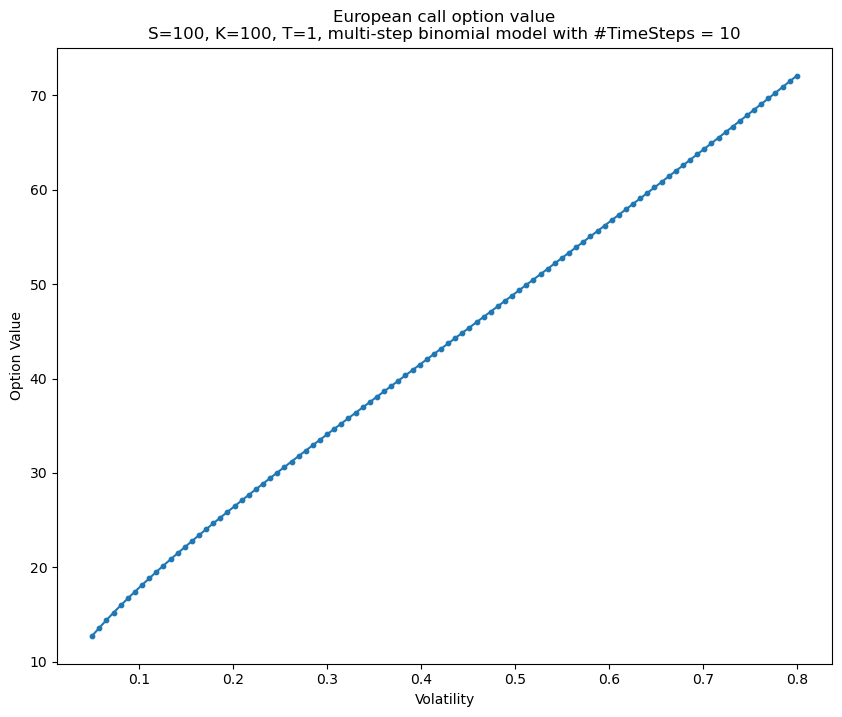

In [59]:
# Option value is given by argument 2 as described in docstring
vols = np.linspace(0.05, 0.80, 100)
opt_values = []
time_steps = 10
# Calculate vector containing all option values for a given standard deviation
for vol in vols:
    sigma = np.sqrt(vol)
    opt_values.append(binomial_option(S, E, r, sigma, T, time_steps, 2)[0, 0])

# plot
plt.figure(figsize=(10, 8))
plt.scatter(x=vols, y=opt_values, marker="o", s=10)
plt.plot(vols, opt_values)  # line to connect the scatter plot
plt.xlabel("Volatility")
plt.ylabel("Option Value")
plt.title(f"European call option value\nS={S}, K={E}, T={T}, multi-step binomial model with #TimeSteps = {time_steps}")
plt.show()

**3.3**: As the time steps increase up to $50$ time steps, we observe convergence of the option value.

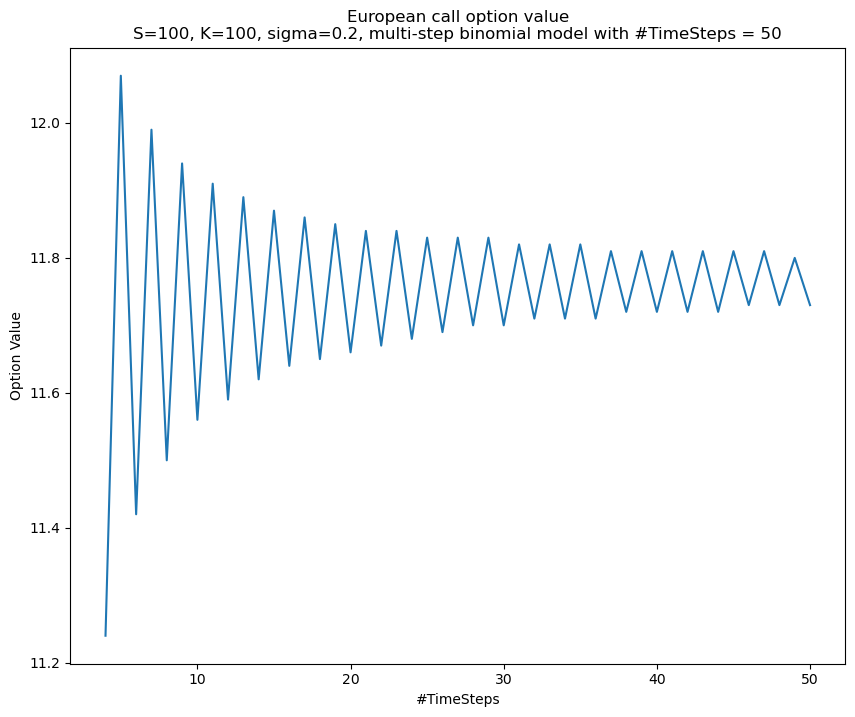

In [60]:
sigma = 0.2
opt_values = []

for time_steps in range(4, 50+1):
    opt_values.append(binomial_option(S, E, r, sigma, T, time_steps, 2)[0, 0])

# plot
plt.figure(figsize=(10, 8))
plt.plot(range(4, 50+1), opt_values)
plt.xlabel("#TimeSteps")
plt.ylabel("Option Value")
plt.title(f"European call option value\nS={S}, K={E}, sigma={sigma}, multi-step binomial model with #TimeSteps = {time_steps}")
plt.show()

## Question 4.1 - VaR + ES:
Derive a standardised formula for$.\text{ES}_c(X)$.

$$
\text{ES}_c(X)  = \mathbb{E}\left[X|X\leq\text{VaR}_c(X)\right]\\
= \frac{1}{1-c}\int_{c}^{1}\text{VaR}_u(X)du\\
$$


where $\text{VaR}(X)=\mu+\Phi^{-1}(1-c)\phi$


## Question 4.2 - ES

Compute ES for a range of percentiles [99.95; 99.75; 99.5; 99.25; 99; 98.5; 98; 97.5].

In [72]:
import pandas as pd
from scipy.stats import norm

percentiles = [99.95, 99.75, 99.5, 99.25, 99, 98.5, 98, 97.5]
es_normal = []
es_std_normal = []


def get_factor_for_es(alpha):
    return norm.pdf(norm.ppf(1 - alpha)) / (1 - alpha)


def get_es(alpha, mu, sigma):
    # calculates Expected Shortfall for confidence level alpha for a r.v. X~N(mu, sigma^2)
    return mu - sigma * get_factor_for_es(alpha)


for percentile in percentiles:
    es_normal.append(f"mu - sigma * {get_factor_for_es(percentile / 100)}")
    es_std_normal.append(get_es(percentile / 100, 0, 1))

df = pd.DataFrame({
    'Percentile': percentiles,
    'Expected Shortfall for X~N(mu, sigma^2)': es_normal,
    'Expected Shortfall for X~N(0, 1)': es_std_normal
})

df

,Percentile,"Expected Shortfall for X~N(mu, sigma^2)","Expected Shortfall for X~N(0, 1)"
0,99.95,mu - sigma * 3.5543806938542857,-3.554381
1,99.75,mu - sigma * 3.104357363203606,-3.104357
2,99.50,mu - sigma * 2.8919486053834813,-2.891949
3,99.25,mu - sigma * 2.761239803172472,-2.761240
4,99.00,mu - sigma * 2.665214220345806,-2.665214
5,98.50,mu - sigma * 2.5246953986002407,-2.524695
6,98.00,mu - sigma * 2.4209067940371014,-2.420907
7,97.50,mu - sigma * 2.3378027922014133,-2.337803
